**IMAGE CLUSTERING - TM 5**

Nama : Salma Ayu Hanifah

NIM : 164221012

Mata kuliah : Data Mining 2

Kelas : SD-A2

# Import Libraries

In [ ]:
pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
%matplotlib inline


Langkah pertama adalah mengimpor library yang diperlukan seperti tensorflow dan mnist digunakan untuk memuat dataset MNIST, matplotlib untuk visualisasi, PCA dan KMeans dari sklearn untuk pemrosesan data dan clustering, serta numpy untuk manipulasi array. Library sklearn.metrics digunakan untuk evaluasi hasil clustering.

# Load Dataset


In [ ]:
# Load Dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Print the shape of training and test data
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


Dataset MNIST diunduh dan dimuat menggunakan mnist.load_data(). Dataset ini berisi gambar tangan dari angka 0 hingga 9, dengan data pelatihan dan pengujian yang masing-masing memiliki dimensi (60000, 28, 28) dan (10000, 28, 28). Data pelatihan terdiri dari 60.000 gambar dan labelnya, sedangkan data pengujian terdiri dari 10.000 gambar dan labelnya.

# Display Sample Image

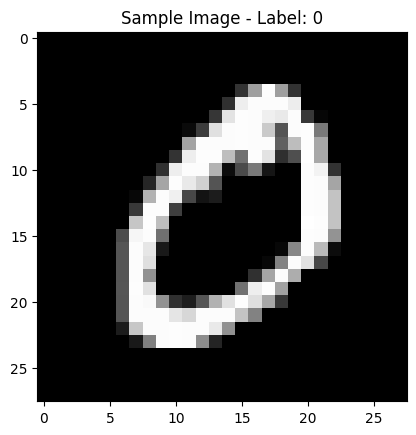

In [ ]:
# Display Sample Image
sample = 1
image = X_train[sample]

plt.imshow(image, cmap='gray')
plt.title(f'Sample Image - Label: {y_train[sample]}')
plt.show()


Satu gambar dari data pelatihan dipilih dan ditampilkan menggunakan matplotlib agar dapat memberikan gambaran tentang format gambar yang digunakan dalam dataset. Output menunjukkan gambar grayscale dari angka 0 yang memiliki label: 0.

# Display Multiple Images (First 10 Images)

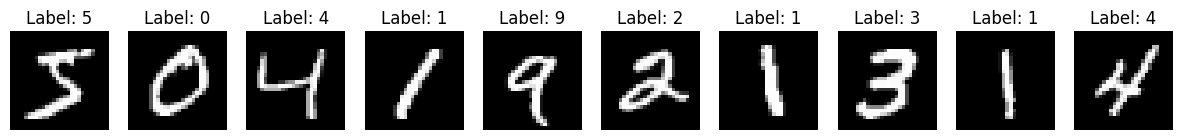

In [ ]:
# Display Multiple Images (First 10 Images)
num = 10
images = X_train[:num]
labels = y_train[:num]

fig, axes = plt.subplots(1, num, figsize=(15, 3))
for i in range(num):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].set_title(f'Label: {labels[i]}')
    axes[i].axis('off')

plt.show()


Menampilkan sepuluh gambar pertama dari data pelatihan dalam susunan baris untuk memberikan gambaran visual tentang variasi angka dalam dataset.

# Prepocessing

## Image Binarizaton

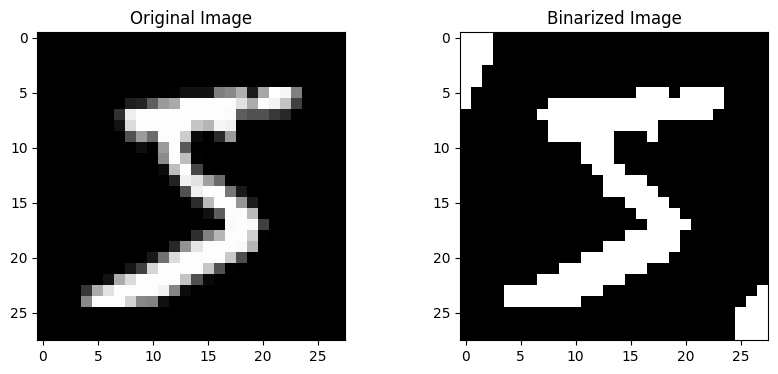

In [ ]:
from skimage.filters import threshold_local

# Fungsi untuk melakukan thresholding lokal dan mengubah gambar menjadi biner
def binarize_images(images, block_size=35, offset=10):
    binary_images = []
    for img in images:
        # Gunakan threshold lokal untuk membuat gambar biner
        local_thresh = threshold_local(img, block_size=block_size, offset=offset)
        binary_img = img > local_thresh
        binary_images.append(binary_img)
    return np.array(binary_images)

block_size = 35
offset = 10

# Asumsikan x_train dan x_test adalah dataset gambar
X_train_binarized = binarize_images(X_train, block_size, offset)
X_test_binarized = binarize_images(X_test, block_size, offset)

# Visualisasi hasil binarisasi gambar
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(X_train_binarized[0], cmap='gray')
plt.title('Binarized Image')
plt.show()


Binarisasi mengubah gambar grayscale menjadi biner (hitam putih), yang berguna dalam beberapa kasus untuk menyederhanakan pola dalam gambar. Visualisasi di sini menunjukkan perbedaan antara gambar asli dan gambar yang telah dibinarisasi.

## Feature Extraction: HOG

In [ ]:
from skimage.feature import hog

# Fungsi untuk mengekstraksi fitur HOG dari gambar
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    hog_features = []
    for img in images:
        # Pastikan gambar dalam grayscale
        if len(img.shape) == 3:
            img = img[:, :, 0]  # Ambil channel pertama jika ada
        # Ekstraksi HOG untuk setiap gambar
        hog_feature = hog(img, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
                          orientations=orientations, block_norm='L2-Hys', visualize=False)
        hog_features.append(hog_feature)
    return np.array(hog_features)

# Ekstraksi fitur HOG dari data binarisasi atau asli
X_train_hog_features = extract_hog_features(X_train_binarized)  # atau X_train jika tanpa binarisasi
X_test_hog_features = extract_hog_features(X_test_binarized)  # atau X_test jika tanpa binarisasi


HOG mengekstraksi fitur dari gambar dalam bentuk vektor yang menggambarkan orientasi dan kekuatan gradien di tiap piksel. Fitur HOG menangkap tepi, sudut, dan pola di gambar, terutama dalam konteks deteksi objek dan pengenalan pola. Ekstraksi dilakukan pada gambar dalam grayscale untuk menyederhanakan komputasi, dan fitur HOG yang diekstraksi akan digunakan sebagai input untuk langkah-langkah berikutnya.

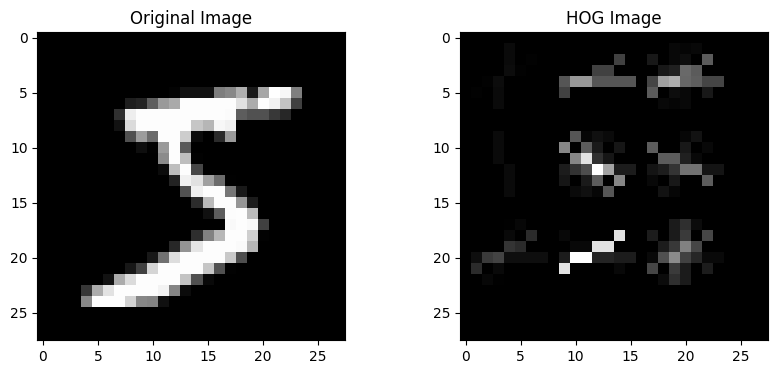

In [ ]:
# Visualisasi salah satu gambar dan fitur HOG-nya
sample_image = X_train[0]  # Pilih salah satu gambar dari dataset

# Ekstraksi HOG dengan visualisasi
hog_feature, hog_image = hog(sample_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                             orientations=9, visualize=True, block_norm='L2-Hys')

# Visualisasi gambar asli dan gambar HOG
plt.figure(figsize=(10, 4))

# Gambar asli
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title('Original Image')

# Gambar HOG
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Image')

plt.show()


Visualisasi ini menunjukkan bagaimana fitur HOG mendeskripsikan pola dalam gambar asli, yaitu dengan menyoroti tepi dan sudut yang dominan di gambar.

## Feature Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler

# Fungsi untuk menstandarisasi fitur HOG
def standardize_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

# Standarisasi fitur HOG
X_train_hog_standardized = standardize_features(X_train_hog_features)
X_test_hog_standardized = standardize_features(X_test_hog_features)


 StandardScaler digunakan untuk melakukan standarisasi fitur HOG. Standarisasi ini penting karena berbagai fitur yang diekstrak mungkin memiliki rentang nilai yang berbeda. Dengan menstandarisasi data, setiap fitur akan memiliki mean 0 dan standar deviasi 1, sehingga meningkatkan kinerja algoritma machine learning yang sensitif terhadap skala data, seperti KMeans.

## Dimensionality Reduction with UMAP

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<ipython-input-11-9ddb12ccad9b>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], s=10, cmap='Spectral')


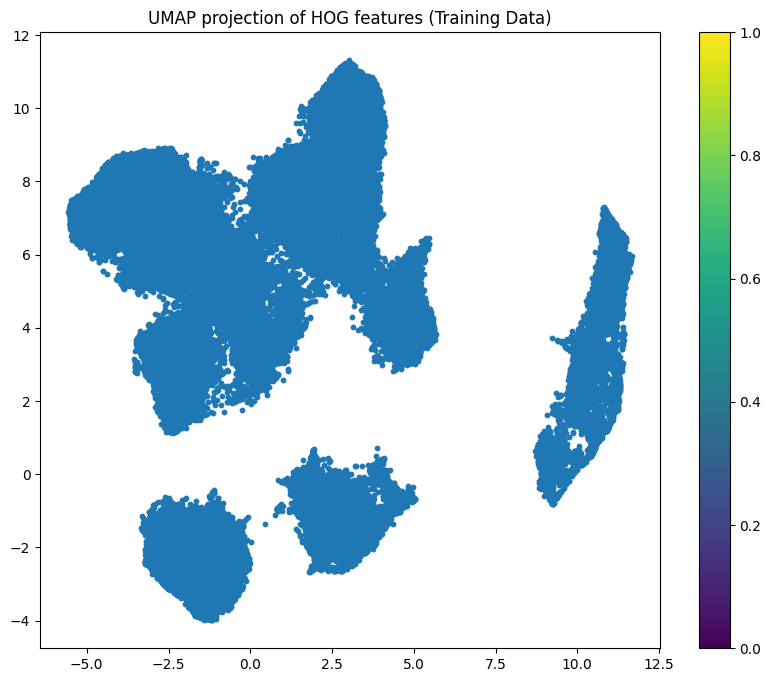

In [ ]:
import umap

# Reduksi dimensi langsung menggunakan UMAP tanpa PCA
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_train_umap = umap_reducer.fit_transform(X_train_hog_standardized)
X_test_umap = umap_reducer.transform(X_test_hog_standardized)

# Visualisasi hasil reduksi UMAP
plt.figure(figsize=(10, 8))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], s=10, cmap='Spectral')
plt.title('UMAP projection of HOG features (Training Data)')
plt.colorbar()
plt.show()


UMAP (Uniform Manifold Approximation and Projection) merupakan teknik reduksi dimensi yang sangat efektif untuk visualisasi data sekaligus mempertahankan struktur topologi. UMAP menurunkan dimensi data yang sangat tinggi (seperti fitur HOG) menjadi hanya 2 komponen utama, yang memudahkan analisis lebih lanjut serta mengurangi beban komputasi untuk algoritma clustering. Dengan proyeksi ini, meskipun data direduksi menjadi dua dimensi, banyak informasi penting tetap dipertahankan. Visualisasi dari hasil UMAP ini memungkinkan kita melihat pola-pola klaster secara lebih jelas, memberikan gambaran tentang bagaimana data terstruktur secara topologi dan mendekatkan titik-titik yang memiliki kesamaan.

# Clustering with KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


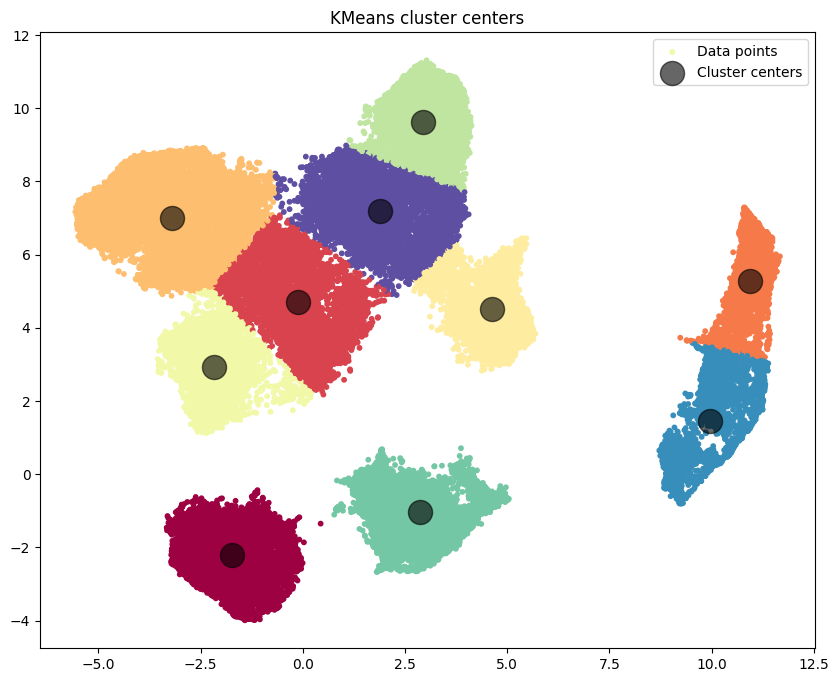

In [ ]:
from sklearn.cluster import KMeans

# Terapkan KMeans clustering
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_train_clusters = kmeans.fit_predict(X_train_umap)
y_test_clusters = kmeans.predict(X_test_umap)

# Visualisasi hasil klastering dengan pusat klaster
plt.figure(figsize=(10, 8))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train_clusters, cmap='Spectral', s=10, label='Data points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', s=300, alpha=0.6, label='Cluster centers')
plt.title('KMeans cluster centers')
plt.legend()
plt.show()


Langkah ini menggunakan algoritma KMeans untuk melakukan pengelompokan data. KMeans berusaha mengelompokkan data ke dalam 10 klaster berdasarkan kemiripan fitur, di mana setiap data akan ditempatkan ke klaster yang memiliki centroid (pusat klaster) terdekat. Hasil pengelompokan ini akan digunakan untuk mengevaluasi kualitas model clustering.

## Evaluate Clustering Performance

In [ ]:
from sklearn.metrics import silhouette_score

# Hitung silhouette score
silhouette_train = silhouette_score(X_train_umap, y_train_clusters)
silhouette_test = silhouette_score(X_test_umap, y_test_clusters)

print(f"Silhouette Score for training data: {silhouette_train:.4f}")
print(f"Silhouette Score for test data: {silhouette_test:.4f}")


# Hitung ARI dan NMI untuk mengevaluasi clustering
ari = adjusted_rand_score(y_test, y_test_clusters)
nmi = normalized_mutual_info_score(y_test, y_test_clusters)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")


Silhouette Score for training data: 0.5294
Silhouette Score for test data: 0.5350
Adjusted Rand Index: 0.6668
Normalized Mutual Information: 0.7515


# Agglomerative Clustering

Silhouette Score digunakan untuk mengukur seberapa baik klaster yang terbentuk memisahkan data. Nilai Silhouette Score berkisar antara -1 hingga 1, di mana nilai yang lebih tinggi menunjukkan bahwa klaster yang terbentuk lebih jelas terpisah dan lebih koheren secara internal. Skor ini digunakan untuk mengevaluasi efektivitas pengelompokan yang dilakukan oleh algoritma KMeans.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=10)
y_agg = agg_clustering.fit_predict(X_test_umap)

# Print clustering labels
print(f"Agglomerative Clustering Labels: {np.unique(y_agg)}")

# Evaluate clustering
agg_silhouette = silhouette_score(X_test_umap, y_agg)
print(f"Silhouette Score: {agg_silhouette:.4f}")

# Evaluate with ARI and NMI
ari_agg = adjusted_rand_score(y_test, y_agg)
nmi_agg = normalized_mutual_info_score(y_test, y_agg)

print(f"Adjusted Rand Index: {ari_agg:.4f}")
print(f"Normalized Mutual Information: {nmi_agg:.4f}")


Agglomerative Clustering Labels: [0 1 2 3 4 5 6 7 8 9]
Silhouette Score: 0.5219
Adjusted Rand Index: 0.6476
Normalized Mutual Information: 0.7447


# DBSCAN Clustering

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_dbscan = dbscan.fit_predict(X_test_umap)

# Print clustering labels
print(f"DBSCAN Labels: {np.unique(y_dbscan)}")

# Evaluate clustering
if len(np.unique(y_dbscan)) > 1:  # Silhouette Score is not defined for a single cluster
    dbscan_silhouette = silhouette_score(X_test_umap, y_dbscan)
    print(f"Silhouette Score: {dbscan_silhouette:.4f}")
else:
    print("Silhouette Score cannot be computed for a single cluster.")

DBSCAN Labels: [-1  0  1  2  3]
Silhouette Score: 0.3563
